In [6]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

### 03. Differential Privacy

[Differential privacy](https://www.microsoft.com/en-us/research/publication/differential-privacy/) is a popular mechanism to quantitatively assess the privacy loss of a given probabilistic query schema or data transformation method. The fundamental equation of differntial privacy is given as

$$ 
\begin{equation}
    \mathrm{Pr}[\mathcal{K}(D_1) \in S] \le exp(\epsilon) \times \mathrm{Pr}[\mathcal{K}(D_2) \in S] \label{eq:dp}
\end{equation}
$$

Here, $\mathrm{Pr}[\mathcal{K}(D_1) \in S]$ is the probability of a
randomized function $\mathcal{K}$ to yield one of values in the $S$ when evaluating
it on a given dataset $D_1$. The right side is identical to the left except
that the function is now evaluated on a dataset $D_2$ that differs from $D_1$
in at most one element. And finally, $\epsilon$ is a parameter that describes
how much information is leaked (or generated) by the function.

Sounds pretty abstract, so let's work out a simple example: Let's assume we want to build a differentially private dataset from the adult data that we've looked at in part 02. The goal here is to protect an adversary from gaining too much information about the sensitive attribute (income > 50.000 \$ or not) when adding that person's data to the dataset. With differential privacy, we look at the state of the dataset before and after a person was added and quantify the privacy loss as given by equation ($\ref{eq:dp}$). Our two schemes are:

* With probability $1-p$, we add a person's true attribute value to the database.
* With probability $p$ we choose a random boolean (0/1) value from a distribution returning $0$ with probability $k$ and $1$ with probability $1-k$ and add that value to the database instead.

Using this scheme, an attacker cannot know with certainty if the real attribute value of the person or a random one was added to the database. This protects the privacy of the person but of course it also adds noise to the database, making it more difficult to use for legitimate users as well.

In practice, we therefore always need to weigh privacy against utility when employing differential privacy. In this notebook, we will calculate the $\epsilon$ and other relevant parameters for our scheme above and see how we can use this differentially private data to make predictions about the income distribution of the people in our dataset.

#### Calculating $\epsilon$

In our differentially private scheme, the probability of adding the true attribute value to the database is $1-p$. The probability of adding a random value is therefore $p$ and the probability of that value being $0$ is $k$. So how can we relate this to eq. (\ref{eq:dp})? Well, $D_1$ and $D_2$ are the versions of our database before and after adding the person's data to it. If an adversary wants to learn the value of the person's attribute, he/she can use a query $\mathcal{K}$ that returns the number of $1$'s in the database. Let's say that before adding the person's data there are $n$ $1$'s in the database. We can then take our set $S = \{n\}$ and calculate the probability that after adding the person's data, $\mathcal{K}(D_2) \in S$. Since we postulate that $n$ $1$'s are in the database before adding the person, we know that $\mathrm{Pr}[\mathcal{K}(D_1) \in \{n\}] = 1$.

Now, there are two relevant cases to consider:

* If a persons's attribute value is $0$, the probability that the value in the database is unchanged after adding the person to the database is given as $1-p+p\cdot k$.
* If a person's attribute value is $1$, the probability that the value in the database is unchanged after adding the person to the database is given as $p\cdot k$.

Since $1-p+p\cdot k > p\cdot k$, the first case provides the bound of the probability in (\ref{eq:dp}), and yields

$$
\begin{equation}
\epsilon = -ln{\left(1-p\cdot(1-k)\right)}
\end{equation}
$$

In [10]:
import numpy as np

def ig(p, k, pa):
    return (1-p*k)/((1-p)*pa+p*(1-k))

def p(k, epsilon):
    return (1-np.exp(-epsilon))/(1-k)


def ko(epsilon):
    return (1+np.exp(-epsilon))/2

In [11]:
epsilon = 0.6
pa = 0.2
ks = np.linspace(0, np.exp(-epsilon), 1000)
igs = ig(p(ks, epsilon), ks, pa);

(1, 1.8218222770964303)

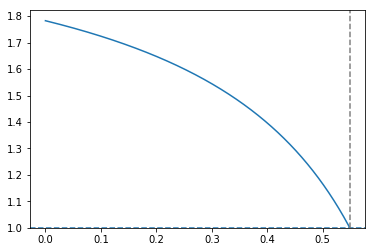

In [12]:
import matplotlib.pylab as pl
pl.plot(ks, igs)
pl.axhline(1, ls='--')
pl.axvline(np.exp(-epsilon), ls='--', color='grey')
pl.ylim(bottom=1)

#### What does this tell us?

Calculating the $\epsilon$ is great, but what does it actually tell us about the privacy loss or risk for our use case? Let's assume an adversary want to learn about the real value of a person's attribute. If she knows the model used for generating the data, she could then use Bayesian reasoning to calculate the probability of a person's attribute being $1$ given the observed difference in the database, which we call $\Delta$. Using Bayes theorem we can calculate this as

$$
\begin{equation}
    P(x_i=1 | \Delta = 1) = P(\Delta = 1| x_i = 1)\cdot \frac{P(x_i=1)}{P(\Delta=0)}
\end{equation}
$$

For our scheme, we know that 

$$
\begin{equation}
    P(\Delta = 1 | x_i = \mathrm{yes}) = (1-p) + p\cdot(1-k) = 1-pk
\end{equation}
$$

and

$$
\begin{equation}
    P(\Delta = 1) = (1-p)\cdot P(x_i = \mathrm{yes}) + p\cdot(1-k)
\end{equation}
$$

so we obtain

$$
\begin{equation}
    P(x_i=yes | \Delta = 1) = \frac{(1-pk)\cdot P(x_i = \mathrm{yes})}{(1-p)\cdot P(x_i = \mathrm{yes})+p\cdot(1-k)}
\end{equation}
$$

Let's see how this relates to $\epsilon$!

In [ ]:
# choose a given k (e.g. 0.5) as well as a value for P(x_i=yes) and plot the conditional probability from eq. (4)
# as a function of p.

In [ ]:
# Plot \epsilon as a function of p for the chosen k.

#### Implementing It

Now that we have a feeling for our scheme we can implement it! For that, we load the "adult census" data from the k-anonymity case study again.

In [8]:
import pandas as pd

names = (
    'age',
    'workclass', #Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
    'fnlwgt', # "weight" of that person in the dataset (i.e. how many people does that person represent) -> https://www.kansascityfed.org/research/datamuseum/cps/coreinfo/keyconcepts/weights
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
)
categorical = set((
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'sex',
    'native-country',
    'race',
    'income',
))
df = pd.read_csv("../data/k-anonymity/adult.all.txt", sep=", ", header=None, names=names, index_col=False, engine='python');# We load the data using Pandas

In [13]:
# Complete the function below so that implements the differentially private data collection scheme as
# discussed above:

def add_to_database(value, p, k):
    pass

In [14]:
# Apply the function to the "income" column (convert the true/false values to 0/1 before)
# to produce a differentially private income data set.

#### Working With The Data

After collecting the differentially private data, we want of course to make use of it! For example, we might want to estimate the probability of a person having an income > 50T\$ based on the data we've collected, which we assume is [Bernoulli distributed](https://en.wikipedia.org/wiki/Bernoulli_distribution) with a probability $p_{inc}$. Now, when collecting data from $n$ persons, the resulting data is then [binomially distributed](https://en.wikipedia.org/wiki/Bernoulli_distribution). The mean of this distribution is given as $\mu_{inc} = n\cdot p_{inc}$ and the variance as $\sigma^2 = n\cdot p \cdot (1-p)$. A consistent and unbiased estimator of $\mu$ is the sum of all values for which $\hat{\mu}_{inc} = \sum_i x_{inc}^i = 1$, which then gives an estimate for $p_{inc}$ of $\hat{p}_{inc} = \hat{\mu}_{inc}/n$.

With our differentially private data things get more complicated as the method might have added a random value instead of the true one to the database. To get an unbiased and consistent estimate of $p_{inc}$, we therefore need to correct for the noise added by the DP schema. Let's do this!

In [ ]:
# Calculate the probability p_{dp} of the differentially private data collection scheme as a function of
# p_{inc}, p and k.

def p_dp(p_inc, p, k):
    pass

In [ ]:
# Construct an unbiased and consistent estimator for p_{inc} from the differentially private data
# when given the number n_{1} of data points with x_i = 1, the total number of data points n
# and the DP parameters p and k
def p_inc(n, n_1, p, k):
    pass

In [ ]:
# Write a function that estimates the variance of the estimator for p_{inc} given the same parameters

def var_inc(n, n_1, p, k):
    pass

In [ ]:
# Plot the variance as a function of the parameter p for a given k, n and n_1